In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
import UnityTransforms as ut
from matplotlib import pyplot as plt
import pickle
import os
from glob import glob
from sklearn.decomposition import PCA as pca
from scipy.optimize import minimize
import imageio
from PIL import Image
from sklearn import kernel_ridge, neighbors
import umap
import umap.plot

%matplotlib inline

%load_ext autoreload
%autoreload 2

C:\Users\markp\anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### Show Log morph was basically the horizontal wall frequency

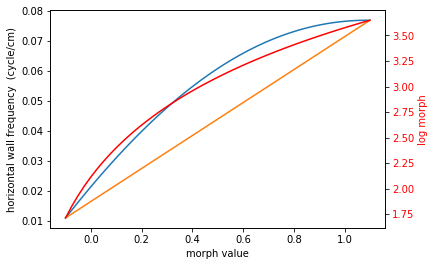

In [2]:
m = np.linspace(-.1,1.1)
f,ax = plt.subplots()
ax.plot(m,ut.xfreq(m)/500)
ax.plot(m,np.linspace(ut.xfreq(-.1),ut.xfreq(1.1))/500)
ax.set_xlabel('morph value')
ax.set_ylabel('horizontal wall frequency  (cycle/cm)')

ax2= ax.twinx()
ax2.plot(m,np.log(np.linspace(ut.xfreq(-.1),ut.xfreq(1.1))),color='red')
ax2.set_ylabel('log morph',color='red')
ax2.tick_params(axis='y',labelcolor='red')

# ax.legend(('actual','morph'))
# ax2.legend('log(morph)')
f.savefig("D:\\Morph_Results\\figures\\wallmorph.png",format="png")

### Run dimensionality reduction on frame grabs from unity

In [3]:
picpath = os.path.join("D:\\","FrameGrabber")

pics = glob(os.path.join(picpath,"*.png"))

In [4]:
stimDict = {}
for pic in pics:
    # get stimulus values from string
    _,stimstr = os.path.split(pic)
    stimstr,_ = os.path.splitext(stimstr)
    stimparts = stimstr.split("_")
    morph = np.float(stimparts[0].split("morph")[1])
    walljit = np.float(stimparts[1].split("wallJit")[1])
    bckgndjit = np.float(stimparts[2].split("bckgndJit")[1])
    towerjit = np.float(stimparts[3].split("towerJit")[1])
    pos = np.float(stimparts[4].split("pos")[1])
    
    stimkey = (morph,walljit,bckgndjit,towerjit)
   
    # if stimulus not yet encountered
    #    make new dictionary key with empty list
    if stimkey not in stimDict.keys():
        stimDict[stimkey]={}
    
    # append file name to dictionary key
    stimDict[stimkey][pos]=pic
    
    
    
    

In [5]:
# check that each list is the same length
positions,keys = [],[]
for i, (k,v) in enumerate(stimDict.items()):
    keys.append(k)
    positions.append(np.sort(np.array([pos for pos in v.keys()])))

old_row = positions[0]
keystokill =[]
for i, new_row in enumerate(positions):
    if old_row.all() != new_row.all():
        print("row %i is improperly formatted" % i)
        print("key",keys[i])
        keystokill.append(keys[i])
        


row 304 is improperly formatted
key (1.0, 0.06922948, -0.01515506, -0.09076788)


In [6]:
# delete messed p entries
for k in keystokill:
    try:  
        stimDict.pop(k)
        keys.remove(k)
    except KeyError:
        print("key not found",k)

C:\Users\markp\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


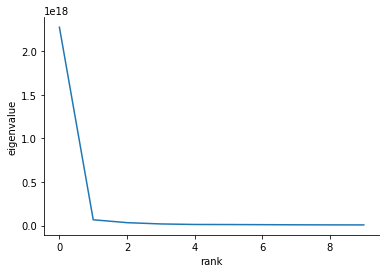

In [21]:
load_prev = True

if load_prev:
    trialcov = np.load("G:\\My Drive\\VR_SreenCapture_TwoTower\\trialcov.npy")
else:

    # load first file, downsample by 4
    pic = Image.open(pics[10])
    f,ax = plt.subplots()
    pic = np.array(pic.resize((int(pic.size[0]/8),int(pic.size[1]/8))))
    ax.imshow(pic)
    pic_fft = np.fft.rfftn(pic,axes=[0,1])
    pic_as = np.abs(pic_fft[:int((pic.shape[0]-1)/2)+1,:])

    # get size of fft

    # n frames per trial
    pos_keys = [pos for pos in positions[0] if pos >0]
    print(pos_keys)
    pos_keys = pos_keys[::20]
    nframes = len(pos_keys)
    print(nframes)


    # n rows is (size of flattened fft of 1 frame) * (number of frames per trial) x (number of stimulus conditions)
    data = np.zeros((int(nframes*pic_as.size*3),len(keys)))
    for i,key in enumerate(keys):
    # save wall morph, tower morph, background morph
        print(key)
        # for each picture
        for j, pos in enumerate(pos_keys):

            #   load file
            f = stimDict[key][pos]
            pic = Image.open(f)
            pic = np.array(pic.resize((int(pic.size[0]/8),int(pic.size[1]/8)))) # downsample
            pic_fft = np.fft.rfftn(pic,axes=[0,1]) # real fft
            pic_as = np.real(pic_fft[:int((pic.shape[0]-1)/2)+1,:]**2) # take power spectrum
            data[j*pic_as.size:(j+1)*pic_as.size,i]=pic_as.ravel()

    # run svd on memory mapped array 
    s = np.linalg.svd(data[:,:],compute_uv=False)
    f,ax = plt.subplots()
    ax.plot(s[:10])
    
    
    trialcov = np.cov(data.T)
keyarr = np.array(keys)
# mask = keyarr[:,1]!=-.1
# keyarr = keyarr[mask,:]


w,v = np.linalg.eig(trialcov)
f,ax = plt.subplots()
ax.plot(w[:10])
ax.set_xlabel("rank")
ax.set_ylabel("eigenvalue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# f.savefig("D:\\Morph_Results\\figures\\stimulus_eig.pdf",format='pdf')


princip = np.real(100*v[:,0])
princip_norm = (princip-np.amin(princip))/(np.amax(princip)-np.amin(princip))
# princip_norm=princip_norm[mask]


[0.009445494973297362, 0.010795028208248476, 0.011852209153092234, 0.011667030754994126, 0.010661119848832706, 0.056103454286415055]


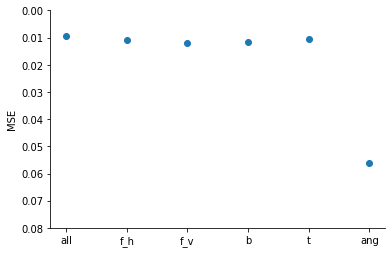

In [22]:
feats = np.zeros((keyarr.shape[0],6))
feats[:,0]=ut.wallmorphx(keyarr[:,0]+keyarr[:,1])
feats[:,1]=ut.wallmorphy(keyarr[:,0]+keyarr[:,1])
feats[:,2]=keyarr[:,2]+keyarr[:,0]
feats[:,3]=keyarr[:,3]+keyarr[:,0]
feats[:,4]=ut.yfreq(keyarr[:,0]+keyarr[:,1])/ut.yfreq(keyarr[:,0]+keyarr[:,1])
feats[:,5]=keyarr[:,0]

lr = sk.linear_model.LinearRegression()
lr.fit(feats,princip_norm)


mse = []
mse.append(((princip_norm-lr.predict(feats))**2).mean())
for j in range(5):
    lr.fit(feats[:,j:j+1],princip_norm)
    mse.append(((princip_norm - lr.predict(feats[:,j:j+1]))**2).mean())
    
print(mse)
f,ax = plt.subplots()
ax.scatter(np.arange(6),mse)
ax.set_ylim([.08,0])
ax.set_xticklabels([0,'all','f_h','f_v', 'b', 't','ang'])
ax.set_ylabel('MSE')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# f.savefig("D:\\Morph_Results\\figures\\morph_proj_regr.pdf",format="pdf")


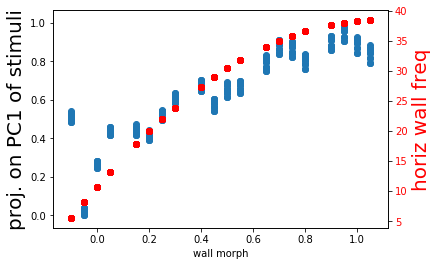

In [23]:
f,ax = plt.subplots()

ax.scatter(keyarr[:,0]+keyarr[:,1],princip_norm)
ax.set_ylabel("proj. on PC1 of stimuli",fontsize=20)
ax.set_xlabel("wall morph")
ax2 = ax.twinx()
# ax2.scatter(keys[mask,0]+keys[mask,1],2*wallmorphx(keys[mask,0]+keys[mask,1])-1.*wallmorphy(keys[mask,0]+keys[mask,1]),color='red')
wmx = ut.xfreq(keyarr[:,0]+keyarr[:,1])
wmy =  ut.wallmorphy(keyarr[:,0]+keyarr[:,1])
ax2.scatter(keyarr[:,0]+keyarr[:,1],wmx ,color='red')
ax2.set_ylabel('horiz wall freq',color='red',fontsize=20)
ax2.tick_params(axis='y',labelcolor='red')
# f.savefig("D:\\Morph_Results\\figures\\stim_fft_v_wallFreq.png",format="png")

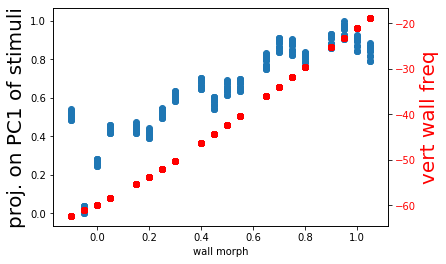

In [24]:
f,ax = plt.subplots()

ax.scatter(keyarr[:,0]+keyarr[:,1],princip_norm)
ax.set_ylabel("proj. on PC1 of stimuli",fontsize=20)
ax.set_xlabel("wall morph")
ax2 = ax.twinx()
# ax2.scatter(keys[mask,0]+keys[mask,1],2*wallmorphx(keys[mask,0]+keys[mask,1])-1.*wallmorphy(keys[mask,0]+keys[mask,1]),color='red')
wmx = ut.xfreq(keyarr[:,0]+keyarr[:,1])
wmy =  ut.yfreq(keyarr[:,0]+keyarr[:,1])
ax2.scatter(keyarr[:,0]+keyarr[:,1],1.1-wmy ,color='red')
ax2.set_ylabel('vert wall freq',color='red',fontsize=20)
ax2.tick_params(axis='y',labelcolor='red')
# f.savefig("D:\\Morph_Results\\figures\\stim_fft_v_vertWallFreq.png",format="png")

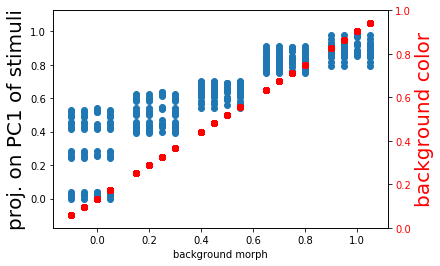

In [25]:
f,ax = plt.subplots()
ax.scatter(keyarr[:,0]+keyarr[:,2],princip_norm)
ax.set_ylabel("proj. on PC1 of stimuli",fontsize=20)
ax.set_xlabel("background morph")
ax2 = ax.twinx()
ax.scatter(keyarr[:,0]+keyarr[:,2],keyarr[:,0]+keyarr[:,2],color='red')
ax2.set_ylabel('background color',color='red',fontsize=20)
ax2.tick_params(axis='y',labelcolor='red')
# f.savefig("D:\\Morph_Results\\figures\\stim_fft_v_bckgnd.png",format="png")

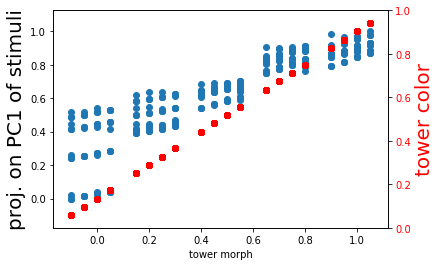

In [26]:
f,ax = plt.subplots()
ax.scatter(keyarr[:,0]+keyarr[:,3],princip_norm)
ax.set_ylabel("proj. on PC1 of stimuli",fontsize=20)
ax.set_xlabel("tower morph")
ax2 = ax.twinx()
ax.scatter(keyarr[:,0]+keyarr[:,3],keyarr[:,0]+keyarr[:,3],color='red')
ax2.set_ylabel('tower color',color='red',fontsize=20)
ax2.tick_params(axis='y',labelcolor='red')
# f.savefig("D:\\Morph_Results\\figures\\stim_fft_v_tower.png",format="png")